In [1]:
import time, gzip
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def show_images(images, cols = 1, titles = None, fontsize='medium'):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        a.set_title(title, fontsize=fontsize)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [3]:
f = gzip.open('./dataset/mnist/train-images-idx3-ubyte.gz', 'r')
image_size = 28
num_images = 60000

f.read(16)
buf = f.read(image_size * image_size * num_images)
dataset_X = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
dataset_X = dataset_X.reshape(num_images, image_size, image_size, 1)

f = gzip.open('./dataset/mnist/train-labels-idx1-ubyte.gz', 'r')
f.read(8)
dataset_Y = []

for i in range(0, num_images):
    buf = f.read(1)
    label = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    dataset_Y.append(label)

In [4]:
X, Y = [], []

class_1 = 1
class_2 = 7

for i in range(len(dataset_Y)):
  if dataset_Y[i] == class_1 or dataset_Y[i] == class_2:
    X.append(dataset_X[i])
    Y.append(dataset_Y[i])

X = np.array(X)
Y = np.array(Y)

In [5]:
print(np.shape(X))
print(np.shape(Y))

(13007, 28, 28, 1)
(13007, 1)


In [6]:
Y = np.where(Y == class_1, 1, -1)
Y = Y.reshape(-1, 1)
print(np.where(Y == -1)[0])

[    4     7     8 ... 13000 13002 13005]


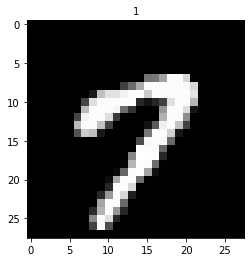

In [7]:
show_images([X[4].reshape(28, 28)], 1, ['1'])

In [8]:
train_cnt = 30

train_index = np.random.choice(len(X), size=train_cnt, replace=False)
test_index = [x for x in np.arange(0, len(X)) if x not in train_index]

train_X = X[train_index]
train_X = train_X.reshape(np.shape(train_X)[0], image_size * image_size)

train_Y = Y[train_index]

test_X = X[test_index]
test_X = test_X[:100]
test_X = test_X.reshape(np.shape(test_X)[0], image_size * image_size)

test_Y = Y[test_index]
test_Y = test_Y[:100]


print(np.shape(train_X))
print(np.shape(train_Y))

print(np.shape(test_X))
print(np.shape(test_Y))

(30, 784)
(30, 1)
(100, 784)
(100, 1)


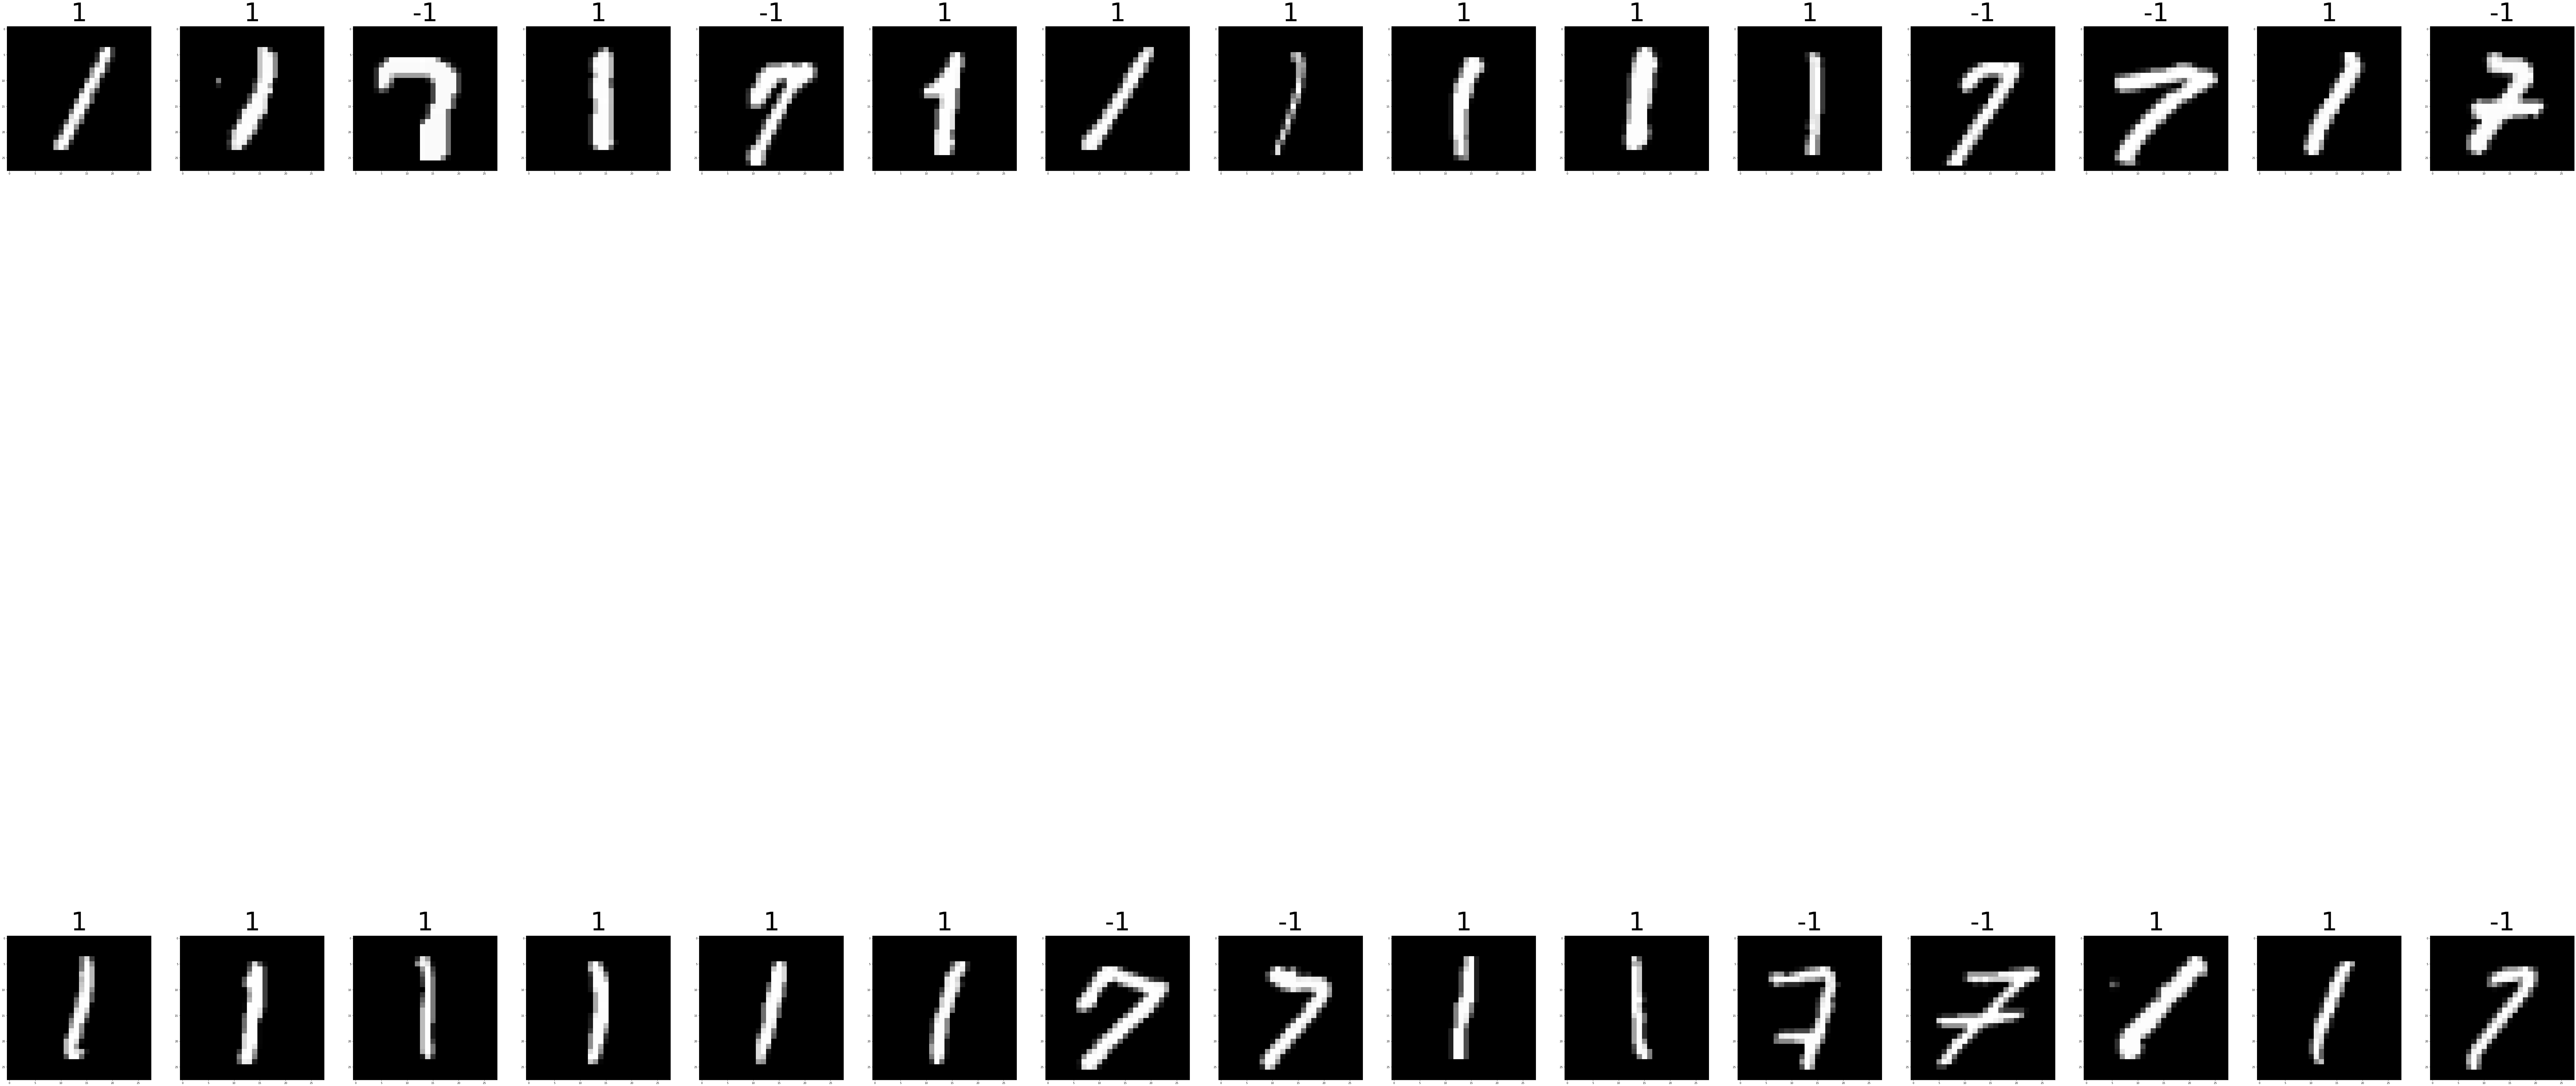

In [9]:
# show_images(
#     train_X.reshape(np.shape(train_X)[0], 28, 28),
#     cols=2,
#     titles=train_Y.squeeze(),
#     fontsize=100)

In [10]:
# show_images(
#     test_X.reshape(np.shape(test_X)[0], 28, 28),
#     cols=2,
#     titles=test_Y.squeeze(),
#     fontsize=100)

In [11]:
BATCH_SIZE = int(np.shape(train_X)[0] / 2)
ITER = 5
LR = 0.01
GAMMA = 1.3

train_X = train_X / 255.
test_X = test_X / 255.

In [12]:
train_X_p = tf.placeholder(shape=[None, np.shape(train_X)[1]], dtype=tf.float32, name='train_X')
train_Y_p = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='train_Y')

b = tf.Variable(tf.random_uniform(shape=[1, BATCH_SIZE]))

pred_X_p = tf.placeholder(shape=[None, np.shape(train_X)[1]], dtype=tf.float32, name='prediction_X')
test_X_p = tf.placeholder(shape=[None, np.shape(test_X)[1]], dtype=tf.float32, name='test_X')
test_Y_p = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='test_Y')

In [13]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i)

  return dtw_array

In [14]:
gamma = tf.constant(GAMMA)
dtw_distances = tf.py_function(func=_dtw, inp=[train_X_p, train_X_p], Tout=[tf.float32 for i in range(BATCH_SIZE)])

kernel = tf.exp(-tf.multiply(gamma, dtw_distances))

In [15]:
first_term = tf.reduce_sum(b)

b_vec_cross = tf.matmul(tf.transpose(b), b)
train_Y_cross = tf.matmul(train_Y_p, tf.transpose(train_Y_p))
second_term = tf.reduce_sum(
    tf.multiply(kernel, tf.multiply(b_vec_cross, train_Y_cross))
)

loss = tf.negative(tf.subtract(first_term, second_term))

In [16]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[train_X_p, pred_X_p], Tout=[tf.float32 for i in range(BATCH_SIZE)])
pred_kernel = tf.exp(-tf.multiply(gamma, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(train_Y_p), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(train_Y_p)), tf.float32))

In [17]:
test_dtw_distances = tf.py_function(func=_dtw, inp=[train_X_p, test_X_p], Tout=[tf.float32 for i in range(BATCH_SIZE)])
test_kernel = tf.exp(-tf.multiply(gamma, test_dtw_distances))

test_prediction_output = tf.matmul(tf.multiply(tf.transpose(train_Y_p), b), test_kernel)
test_prediction = tf.sign(test_prediction_output - tf.reduce_mean(test_prediction_output))

test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(test_prediction), tf.squeeze(test_Y_p)), tf.float32))

In [18]:
optimizer = tf.train.GradientDescentOptimizer(LR)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [19]:
start = time.time()

loss_vec = []
batch_accuracy = []

for i in range(ITER):
  print('Step #' + str(i+1))
  local_start = time.time()

  rand_index = np.random.choice(len(train_X), size=BATCH_SIZE, replace=False)
  rand_X = train_X[rand_index]
  rand_Y = train_Y[rand_index]

  sess.run(train, feed_dict={train_X_p: rand_X, train_Y_p: rand_Y})
  temp_loss = sess.run(loss, feed_dict={train_X_p: rand_X, train_Y_p: rand_Y})
  loss_vec.append(temp_loss)

  acc_temp = sess.run(accuracy, feed_dict={train_X_p: rand_X, train_Y_p: rand_Y, pred_X_p: rand_X})
  batch_accuracy.append(acc_temp)

  print("accuracy :", acc_temp)
  print("loss:", str(temp_loss))
  print("time :", time.time() - local_start)

print("Total time :", time.time() - start)

Step #1
accuracy : 0.73333335
loss: -2.2717068
time : 137.38497877120972
Step #2
accuracy : 0.93333334
loss: -2.330242
time : 135.7178659439087
Step #3
accuracy : 0.73333335
loss: -2.3864634
time : 133.8075568675995
Step #4
accuracy : 0.8
loss: -2.4404547
time : 133.7234480381012
Step #5
accuracy : 0.8666667
loss: -2.4923184
time : 131.84841179847717
Total time : 672.4830777645111


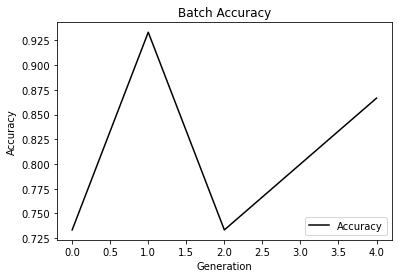

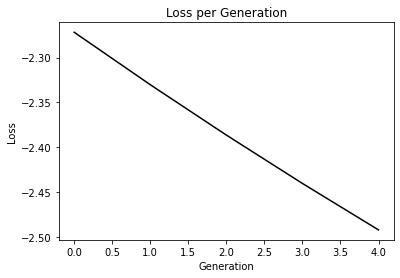

In [20]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [21]:
test_accuracy = sess.run(test_accuracy,
                         feed_dict={
                           train_X_p: train_X[rand_index],
                           train_Y_p: train_Y[rand_index],
                           test_X_p: test_X,
                           test_Y_p: test_Y
                           })
print(test_accuracy)

0.68


In [22]:
test_predictions = sess.run(test_prediction,
                    feed_dict={
                      train_X_p: train_X[rand_index],
                      train_Y_p: train_Y[rand_index],
                      test_X_p: test_X
                    })
test_predictions = np.squeeze(test_predictions)
test_Y = np.squeeze(test_Y)

In [ ]:
# images = test_X[:10]
# show_images(
#     test_X.reshape(np.shape(test_X)[0], image_size, image_size),
#     5,
#     titles=test_predictions,
#     fontsize=100)

In [ ]:
train_grad = tf.gradients(loss, b)
grad = sess.run(train_grad, feed_dict={train_X_p: train_X[rand_index], train_Y_p: train_Y[rand_index]})
grad = grad[0]

In [ ]:
train_hess = tf.hessians(loss, b)
hess = sess.run(train_hess, feed_dict={train_X_p: train_X[rand_index], train_Y_p: train_Y[rand_index]})
hess = np.squeeze(hess)

In [ ]:
inverse_hess = np.linalg.inv(hess)
print(inverse_hess)
print(np.shape(inverse_hess))

In [ ]:
print(np.shape(grad))
print(np.shape(inverse_hess))

influence = -(grad @ inverse_hess @ np.transpose(grad))
print(influence)